In [1]:
! pip install -U scikit-learn

In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [3]:
! wget -nc --content-disposition --header="API-Key: e2697a415abd570c10a94b88d11b044a" "http://www.tng-project.org/api/TNG100-1/files/stellar_photometry.91.hdf5"

URL transformed to HTTPS due to an HSTS policy
--2023-10-19 14:29:55--  https://www.tng-project.org/api/TNG100-1/files/stellar_photometry.91.hdf5
Resolving www.tng-project.org (www.tng-project.org)... 130.183.17.94
Connecting to www.tng-project.org (www.tng-project.org)|130.183.17.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data-eu.tng-project.org/file/stellar_photometry/L75n1820TNG/91/?token=32f26f810fa1757f7b82 [following]
--2023-10-19 14:29:55--  https://data-eu.tng-project.org/file/stellar_photometry/L75n1820TNG/91/?token=32f26f810fa1757f7b82
Resolving data-eu.tng-project.org (data-eu.tng-project.org)... 130.183.17.94
Connecting to data-eu.tng-project.org (data-eu.tng-project.org)|130.183.17.94|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [4]:
import h5py

with h5py.File('Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_091.hdf5', 'r') as hf:
    print (list (hf.keys()))
    s_id = hf['subhaloIDs'][:]
    phot = hf['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:]

['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']


In [5]:
s_id.shape

(4449889,)

In [6]:
basePath = '../sims.TNG/TNG100-1/output'

In [7]:
mtype = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloMassType'])
gmetal = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloGasMetallicity'])
sfr = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloSFR'])

In [8]:
sfr.shape

(4449889,)

In [9]:
pdgmetal = pd.DataFrame(gmetal, columns=['Gas Metallicity'])
pdsfr = pd.DataFrame(sfr, columns=['Stellar Formation Rate'])
pds_id = pd.DataFrame(s_id, columns =['Subhalo ID'])

In [10]:
gmass = mtype[:,0]
dmmass = mtype[:,1]
stmass = mtype[:,4]
bhmass = mtype[:,5]

In [11]:
pdgmass = np.log10((pd.DataFrame(gmass, columns=['Gas Mass']))*(10**10))
pddmmass = np.log10((pd.DataFrame(dmmass, columns=['Dark Matter Mass']))*(10**10))
pdstmass = np.log10((pd.DataFrame(stmass, columns=['Stellar Mass']))*(10**10))
pdbhmass = np.log10((pd.DataFrame(bhmass, columns=['Black Hole Mass']))*(10**10))

/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [12]:
pdgmass

,Gas Mass
0,13.560769
1,10.616130
2,9.833848
3,8.702189
4,10.616083
...,...
4449884,-inf
4449885,-inf
4449886,-inf
4449887,-inf


In [13]:
pdgmetal.replace(to_replace = 0, value = 10**-8, inplace=True)
pdsfr.replace(to_replace = 0, value = 10**-8, inplace=True)
pdgmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pddmmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pdstmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pdbhmass.replace(to_replace = -np.inf, value = 8, inplace=True) 

pdgmetal.fillna(0,inplace=True)
pdsfr.fillna(0,inplace=True)
pdgmass.fillna(0,inplace=True)
pddmmass.fillna(0,inplace=True)
pdstmass.fillna(0,inplace=True)
pdbhmass.fillna(0,inplace=True)

In [14]:
df = pd.DataFrame(pdgmetal)
df['Stellar Formation Rate'] = pdsfr
df['Gas Mass'] = pdgmass
df['Stellar Mass'] = pdstmass
df['Black Hole Mass'] = pdbhmass
df['Dark Matter Mass'] = pddmmass
df['Subhalo ID'] = pds_id

In [15]:
df['Stellar Mass'] = df['Stellar Mass'][(df['Stellar Mass'] > 9)]
df['Gas Mass'] = df['Gas Mass'][(df['Gas Mass'] > 9)]
df['Black Hole Mass'] = df['Black Hole Mass'][(df['Gas Mass'] > 9)]
df['Dark Matter Mass'] = df['Dark Matter Mass'][(df['Dark Matter Mass'] > 9)]

In [16]:
df

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2
3,1.192400e-02,1.000000e-08,NaN,11.214507,NaN,12.363271,3
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4
...,...,...,...,...,...,...,...
4449884,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN,4449884
4449885,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN,4449885
4449886,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN,4449886
4449887,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN,4449887


In [17]:
ddf = df.dropna()

In [18]:
ddf

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID
0,0.003920,11.912257,13.560769,12.189700,9.722685,14.337951,0
1,0.018736,30.788357,10.616130,11.680132,9.218714,12.360020,1
2,0.015765,1.733503,9.833848,11.401999,8.900289,12.290783,2
4,0.010475,1.204401,10.616083,11.025040,8.616725,12.339453,4
5,0.010222,0.159784,10.349733,11.027364,8.619128,12.318265,5
...,...,...,...,...,...,...,...
690845,0.013595,0.038821,9.093002,9.090375,6.483581,10.578035,690845
699400,0.010813,0.003104,9.260669,9.051264,6.359085,10.582078,699400
699823,0.018197,0.032678,9.432016,9.128754,6.150613,10.545896,699823
701978,0.013865,0.003220,9.218776,9.023348,6.424880,10.593871,701978


In [19]:
reshaped_phot = phot.reshape(4449889, 8 * 12)

colu = []
for f in range(8):
    for sub in range(12):
        colu.append(f'feature_{f}_sub_{sub}')
ph = pd.DataFrame(data=reshaped_phot, columns=colu)
ph['Subhalo ID'] = pds_id

matching_elements = []
for i in ph['Subhalo ID']:
    if i in ddf['Subhalo ID'].values:
        matching_elements.append(i)
    else :
        matching_elements.append(np.nan)     
matching_series = pd.Series(matching_elements)

In [20]:
matching_elements = np.zeros(len(ph['Subhalo ID']))
for idx, i in enumerate(ph['Subhalo ID']):
    if i in ddf['Subhalo ID'].values:
        matching_elements[idx] = i
    else :
        matching_elements[idx] = np.nan
                             
matching_series = pd.Series(matching_elements)

In [21]:
matching_series

0          0.0
1          1.0
2          2.0
3          NaN
4          4.0
          ... 
4449884    NaN
4449885    NaN
4449886    NaN
4449887    NaN
4449888    NaN
Length: 4449889, dtype: float64

In [22]:
#pph = ph.dropna()
#for f in range(8):
    #for sub in range(1, 12):
        #pph = pph.drop(columns=(f'feature_{f}_sub_{sub}'))

In [23]:
pph = ph.dropna()
for f in range(8):
    for sub in range(1, 12):
        pph = pph.drop(columns=(f'feature_{f}_sub_{sub}'))   
    if f > 4: 
        pph = pph.drop(columns=(f'feature_{f}_sub_0'))

In [24]:
pph['u-g'] = pph['feature_0_sub_0'] - pph['feature_1_sub_0']
pph['g-r'] = pph['feature_1_sub_0'] - pph['feature_2_sub_0']
pph['r-i'] = pph['feature_2_sub_0'] - pph['feature_3_sub_0']
pph['i-z'] = pph['feature_3_sub_0'] - pph['feature_4_sub_0']

In [25]:
pph['Matched IDs'] = matching_series
ppph = pph.dropna()

In [26]:
ppph['Matched IDs'] = ppph['Matched IDs'].astype(int)

/tmp/ipykernel_25/1382364284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppph['Matched IDs'] = ppph['Matched IDs'].astype(int)


In [27]:
ppph

,feature_0_sub_0,feature_1_sub_0,feature_2_sub_0,feature_3_sub_0,feature_4_sub_0,Subhalo ID,u-g,g-r,r-i,i-z,Matched IDs
0,-20.593021,-22.422171,-23.232534,-23.637362,-23.995768,0,1.829149,0.810364,0.404827,0.358406,0
1,-21.890554,-23.154871,-23.729202,-24.056564,-24.364653,1,1.264317,0.574331,0.327362,0.308088,1
2,-20.367485,-21.993053,-22.700130,-23.067825,-23.393227,2,1.625568,0.707077,0.367695,0.325401,2
4,-19.595139,-21.141136,-21.839962,-22.205723,-22.526999,4,1.545998,0.698826,0.365761,0.321276,4
5,-19.548655,-21.221619,-21.958494,-22.332056,-22.652355,5,1.672964,0.736876,0.373562,0.320299,5
...,...,...,...,...,...,...,...,...,...,...,...
690845,-15.743291,-17.119652,-17.737516,-18.063692,-18.327505,690845,1.376361,0.617865,0.326176,0.263813,690845
699400,-15.431806,-16.861910,-17.513439,-17.847158,-18.104263,699400,1.430104,0.651529,0.333719,0.257105,699400
699823,-15.837831,-17.212599,-17.827396,-18.158398,-18.434526,699823,1.374768,0.614798,0.331001,0.276129,699823
701978,-15.251475,-16.737135,-17.381107,-17.710775,-17.962017,701978,1.485660,0.643972,0.329668,0.251242,701978


In [28]:
co = ddf.merge(pph, how = 'inner')

In [29]:
co

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID,feature_0_sub_0,feature_1_sub_0,feature_2_sub_0,feature_3_sub_0,feature_4_sub_0,u-g,g-r,r-i,i-z,Matched IDs
0,0.003920,11.912257,13.560769,12.189700,9.722685,14.337951,0,-20.593021,-22.422171,-23.232534,-23.637362,-23.995768,1.829149,0.810364,0.404827,0.358406,0.0
1,0.018736,30.788357,10.616130,11.680132,9.218714,12.360020,1,-21.890554,-23.154871,-23.729202,-24.056564,-24.364653,1.264317,0.574331,0.327362,0.308088,1.0
2,0.015765,1.733503,9.833848,11.401999,8.900289,12.290783,2,-20.367485,-21.993053,-22.700130,-23.067825,-23.393227,1.625568,0.707077,0.367695,0.325401,2.0
3,0.010475,1.204401,10.616083,11.025040,8.616725,12.339453,4,-19.595139,-21.141136,-21.839962,-22.205723,-22.526999,1.545998,0.698826,0.365761,0.321276,4.0
4,0.010222,0.159784,10.349733,11.027364,8.619128,12.318265,5,-19.548655,-21.221619,-21.958494,-22.332056,-22.652355,1.672964,0.736876,0.373562,0.320299,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14048,0.013595,0.038821,9.093002,9.090375,6.483581,10.578035,690845,-15.743291,-17.119652,-17.737516,-18.063692,-18.327505,1.376361,0.617865,0.326176,0.263813,690845.0
14049,0.010813,0.003104,9.260669,9.051264,6.359085,10.582078,699400,-15.431806,-16.861910,-17.513439,-17.847158,-18.104263,1.430104,0.651529,0.333719,0.257105,699400.0
14050,0.018197,0.032678,9.432016,9.128754,6.150613,10.545896,699823,-15.837831,-17.212599,-17.827396,-18.158398,-18.434526,1.374768,0.614798,0.331001,0.276129,699823.0
14051,0.013865,0.003220,9.218776,9.023348,6.424880,10.593871,701978,-15.251475,-16.737135,-17.381107,-17.710775,-17.962017,1.485660,0.643972,0.329668,0.251242,701978.0


In [30]:
#Features = co[['feature_0_sub_0','feature_1_sub_0','feature_2_sub_0','feature_3_sub_0','feature_4_sub_0','feature_5_sub_0','feature_6_sub_0','feature_7_sub_0']]
#Target = co['Dark Matter Mass']
#X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.1)

In [30]:
Features = co[['u-g','g-r','r-i','i-z', 'feature_0_sub_0','feature_1_sub_0','feature_2_sub_0','feature_3_sub_0','feature_4_sub_0']]
Target = co['Dark Matter Mass']
X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.1)

In [31]:
X_train.shape

(12647, 9)

In [32]:
Target.shape

(14053,)

prediction :  [10.72035885 11.0864687  11.26830959 ... 11.05282974 11.17794323
 11.46127224]
R2 Score :  0.4927909138323373
The mean square value :  0.14934557053181158
The Score :  {'fit_time': array([0.29794168, 0.26692724, 0.33787227, 0.37919784, 0.39488459,
       0.28969336, 0.26258469]), 'score_time': array([0.00358009, 0.00356293, 0.0042758 , 0.0050261 , 0.00546169,
       0.00336981, 0.00307894]), 'test_score': array([0.44987165, 0.45662528, 0.48962882, 0.47657371, 0.4933053 ,
       0.48821562, 0.43354372]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.46968058553877473
Train Score :  1.0
Cross Vaidate prediction :  [14.02041245 13.42391777 13.15648746 ... 10.64559555 10.4722023
 10.80197906]


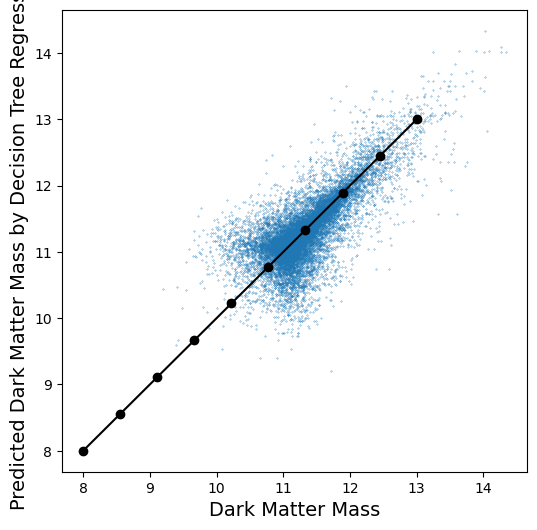

In [32]:
Regressor = DecisionTreeRegressor()
Regressor.fit(X_train, Y_train)
Y_pred = Regressor.predict(X_test)
print ("prediction : ", Y_pred)

R = r2_score(Y_test, Y_pred)
print ("R2 Score : ", R)

Mse = mean_squared_error(Y_test, Y_pred)
print ("The mean square value : ", Mse)

Scores = cross_validate(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
S = np.mean(Scores['test_score'])
print ("The Score : ", Scores)
print ("Test Score : ", S)
print ("Train Score : ", np.mean(Scores['train_score']))

Cvpred = cross_val_predict(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", Cvpred)

m = np.linspace(8, 13, 10)
n = m

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(Target,Cvpred, '.', markersize=0.5)
ax.plot(m, n, color='black', linestyle='-', marker='o')
ax.set_xlabel('Dark Matter Mass', fontsize=14)
ax.set_ylabel('Predicted Dark Matter Mass by Decision Tree Regressor',fontsize=14)
plt.show()

prediction :  [10.72035885 11.01396847 11.26830959 ... 11.05282974 11.17794323
 11.46127224]
R2 Score :  0.49703531185151084
The mean square value :  0.1480958254838137
The Score :  {'fit_time': array([0.27365446, 0.2749567 , 0.28667784, 0.25959563, 0.2865715 ,
       0.2685411 , 0.30454302]), 'score_time': array([0.00333667, 0.0032897 , 0.00406146, 0.0032835 , 0.00334764,
       0.00382662, 0.00532889]), 'test_score': array([0.46380543, 0.45519053, 0.48288081, 0.4830835 , 0.48716963,
       0.46757175, 0.45394373]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.4705207693874495
Train Score :  1.0
Cross Vaidate prediction :  [14.02041245 13.42391777 13.15648746 ... 10.64559555 10.4722023
 10.47367954]
Pearson Correlation Coefficient: 0.7380259114630179
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Decision Tree Regressor')

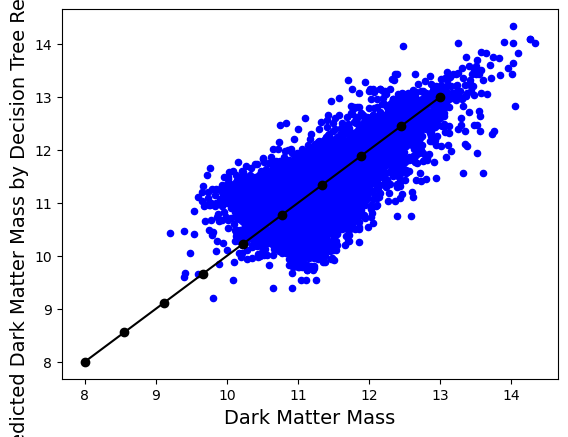

In [33]:
Regressor = DecisionTreeRegressor()
Regressor.fit(X_train, Y_train)
Y_pred = Regressor.predict(X_test)
print ("prediction : ", Y_pred)

R = r2_score(Y_test, Y_pred)
print ("R2 Score : ", R)

Mse = mean_squared_error(Y_test, Y_pred)
print ("The mean square value : ", Mse)

Scores = cross_validate(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
S = np.mean(Scores['test_score'])
print ("The Score : ", Scores)
print ("Test Score : ", S)
print ("Train Score : ", np.mean(Scores['train_score']))

Cvpred = cross_val_predict(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", Cvpred)

C_coeff, P_value = stats.pearsonr(Cvpred.reshape((14053,)), Target)
print("Pearson Correlation Coefficient:", C_coeff)
print("P-value:", P_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,Cvpred, s = 20, c = 'blue')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Decision Tree Regressor',fontsize=14)

prediction :  [10.962814 10.82163  11.362884 ... 11.113895 11.096414 11.486267]
R2 Score :  0.676488835169823
The mean square value :  0.09525649
The Score :  {'fit_time': array([0.03967381, 0.04002309, 0.04211974, 0.04522848, 0.04026914,
       0.04038239, 0.04011154]), 'score_time': array([0.01698589, 0.01694655, 0.01960516, 0.01757956, 0.01798391,
       0.01767993, 0.0171113 ]), 'test_score': array([0.6733551 , 0.65073822, 0.67611854, 0.62747422, 0.63944694,
       0.65210845, 0.63684052]), 'train_score': array([0.82576821, 0.82624508, 0.82608038, 0.82766068, 0.82704787,
       0.82578727, 0.82656102])}
Test Score :  0.6508688563226473
Train Score :  0.8264500721080709
Cross Vaidate prediction :  [13.789246 13.829872 13.174065 ... 10.712276 10.622312 10.568458]
Pearson Correlation Coefficient: 0.8115956202504107
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by KNN Regressor')

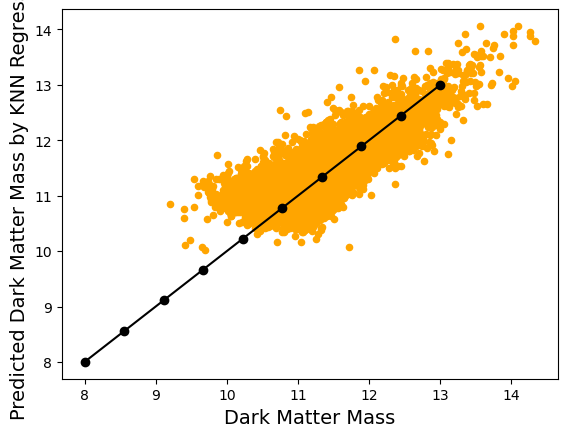

In [34]:
KnnRegressor = KNeighborsRegressor(n_neighbors=3)
KnnRegressor.fit(X_train, Y_train)
KY_pred = KnnRegressor.predict(X_test)
print ("prediction : ", KY_pred)

KR = r2_score(Y_test, KY_pred)
print ("R2 Score : ", KR)

KMse = mean_squared_error(Y_test, KY_pred)
print ("The mean square value : ", KMse)

KScores = cross_validate(KnnRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
KS = np.mean(KScores['test_score'])
print ("The Score : ", KScores)
print ("Test Score : ", KS)
print ("Train Score : ", np.mean(KScores['train_score']))

KCvpred = cross_val_predict(KnnRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", KCvpred)

KC_coeff, KP_value = stats.pearsonr(KCvpred.reshape((14053,)), Target)
print("Pearson Correlation Coefficient:", KC_coeff)
print("P-value:", KP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,KCvpred, s = 20, c = 'orange')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by KNN Regressor',fontsize=14)

prediction :  [10.706711  10.82358   11.196929  ... 10.870622  11.0809555 11.573624 ]
R2 Score :  0.7031087553029167
The mean square value :  0.08741837
The Score :  {'fit_time': array([0.02066684, 0.03526092, 0.05014205, 0.02860022, 0.03298473,
       0.0283978 , 0.03391981]), 'score_time': array([0.01783943, 0.05958366, 0.05223656, 0.05468774, 0.01351953,
       0.04808569, 0.02742004]), 'test_score': array([0.70826959, 0.66772489, 0.70537381, 0.66734506, 0.6809296 ,
       0.6825923 , 0.67594747]), 'train_score': array([0.68091416, 0.68750154, 0.68097008, 0.68762436, 0.68539749,
       0.68512613, 0.68619616])}
Test Score :  0.6840261027416092
Train Score :  0.6848185607100463
Cross Vaidate prediction :  [12.838615 12.846898 12.602707 ... 10.791036 10.761793 10.745863]
Pearson Correlation Coefficient: 0.8273207142542808
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Linear Regressor')

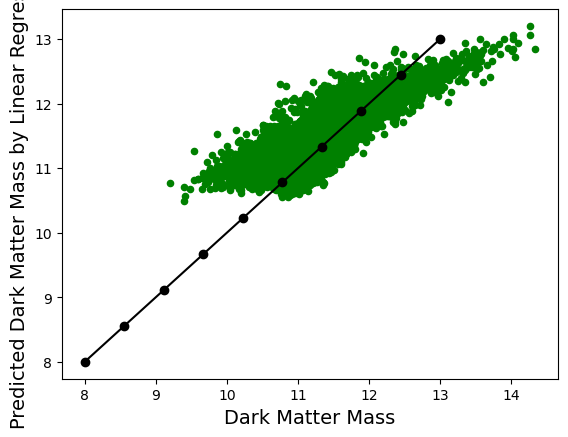

In [35]:
LRegressor = LinearRegression()
LRegressor.fit(X_train, Y_train)
LY_pred = LRegressor.predict(X_test)
print ("prediction : ", LY_pred)

LR = r2_score(Y_test, LY_pred)
print ("R2 Score : ", LR)

LMse = mean_squared_error(Y_test, LY_pred)
print ("The mean square value : ", LMse)

LScores = cross_validate(LRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
LS = np.mean(LScores['test_score'])
print ("The Score : ", LScores)
print ("Test Score : ", LS)
print ("Train Score : ", np.mean(LScores['train_score']))

LCvpred = cross_val_predict(LRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", LCvpred)

LC_coeff, LP_value = stats.pearsonr(LCvpred.reshape((14053,)), Target)
print("Pearson Correlation Coefficient:", LC_coeff)
print("P-value:", LP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,LCvpred, s = 20, c = 'green')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Linear Regressor',fontsize=14)

In [39]:
scaler = StandardScaler()
yscaler = StandardScaler()

# Fit and transform the scaler on the training data, then transform the testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

FORegressor = RandomForestRegressor()
FORegressor.fit(X_train_scaled, Y_train)
FOY_pred = FORegressor.predict(X_test_scaled)
print ("prediction : ", FOY_pred)

FOR = r2_score(Y_test, FOY_pred)
print ("R2 Score : ", FOR)

FOMse = mean_squared_error(Y_test, FOY_pred)
print ("The mean square value : ", FOMse)

FOScores = cross_validate(FORegressor,X_train_scaled,Y_train_scaled, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
FOS = np.mean(FOScores['test_score'])
print ("The Score : ", FOScores)
print ("Test Score : ", FOS)
print ("Train Score : ", np.mean(FOScores['train_score']))

FOCvpred = cross_val_predict(FORegressor,X_train_scaled,Y_train_scaled, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", FOCvpred)

FC_coeff, FP_value = stats.pearsonr(FOCvpred.reshape((12647,)), Target)
print("Pearson Correlation Coefficient:", FC_coeff)
print("P-value:", FP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,FOCvpred, s = 20, c = 'red')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Random Forest Regressor',fontsize=14)

AttributeError: 'StandardScaler' object has no attribute 'inverse_fit_transform'

prediction :  [10.75613394 10.89421376 11.31608257 ... 10.99622215 11.1008417
 11.48724057]
R2 Score :  0.715013832278508
The mean square value :  0.08391297193357394
The Score :  {'fit_time': array([4.09593058, 4.00190735, 4.08432841, 3.97698712, 4.5385623 ,
       4.13028789, 4.15466928]), 'score_time': array([0.10478973, 0.09710526, 0.10358834, 0.09749794, 0.09913421,
       0.1308229 , 0.09841371]), 'test_score': array([0.71082838, 0.70225968, 0.72588744, 0.69580199, 0.70234259,
       0.69642319, 0.69224751]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.7036843992097251
Train Score :  1.0
Cross Vaidate prediction :  [14.00167655 13.39205807 13.17157977 ... 10.6578168  10.59362922
 10.73745831]
Pearson Correlation Coefficient: 0.8403173844292467
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Extreme Random Forest Regressor')

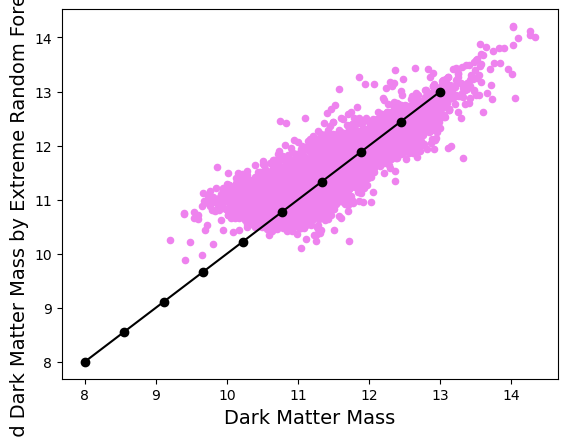

In [37]:
ETRegressor = ExtraTreesRegressor(n_estimators=100, random_state=33)
ETRegressor.fit(X_train, Y_train)
ETY_pred = ETRegressor.predict(X_test)
print ("prediction : ", ETY_pred)

ETR = r2_score(Y_test, ETY_pred)
print ("R2 Score : ", ETR)

ETMse = mean_squared_error(Y_test, ETY_pred)
print ("The mean square value : ", ETMse)

ETScores = cross_validate(ETRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
ETS = np.mean(ETScores['test_score'])
print ("The Score : ", ETScores)
print ("Test Score : ", ETS)
print ("Train Score : ", np.mean(ETScores['train_score']))

ETCvpred = cross_val_predict(ETRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", ETCvpred)

ETC_coeff, ETP_value = stats.pearsonr(ETCvpred.reshape((14053,)), Target)
print("Pearson Correlation Coefficient:", ETC_coeff)
print("P-value:", ETP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,ETCvpred, s = 20, c = 'violet')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Extreme Random Forest Regressor',fontsize=14)

 Model Comparisons for Case 2 


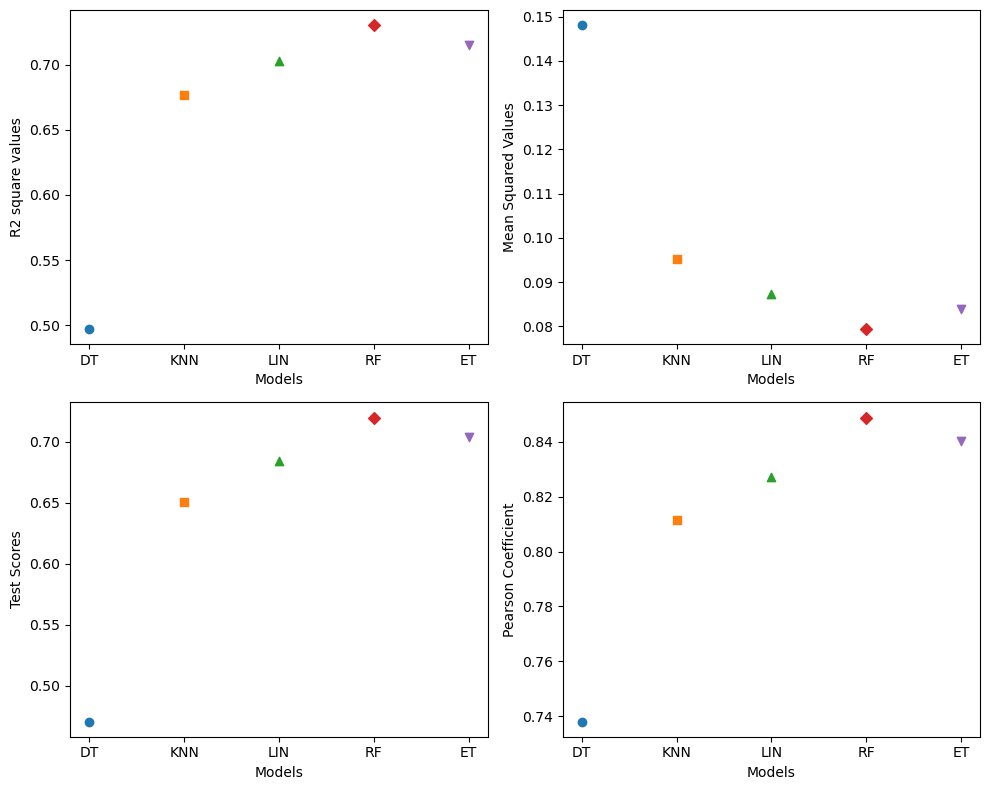

In [38]:
# COMPARISON GRAPH (CASE 2)

print ("\033[1m Model Comparisons for Case 2 \033[0m")

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
#R square
plt.plot(figsize=(4, 4))
g = [R, KR, LR, FOR, ETR]
h = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for i in range(len(g)):
    plt.scatter(h[i], g[i], marker=shapes[i])
plt.xlabel('Models')
plt.ylabel('R2 square values')

#Mean Squared Error

plt.subplot(2, 2, 2)
plt.plot(figsize=(4, 4))
gg = [Mse, KMse, LMse, FOMse, ETMse]
hh = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for i in range(len(gg)):
    plt.scatter(hh[i], gg[i], marker=shapes[i])
plt.xlabel('Models')
plt.ylabel('Mean Squared Values')

#Test Scores

plt.subplot(2, 2, 3)
plt.plot(figsize=(4, 4))
G = [S, KS, LS, FOS, ETS]
H = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for j in range(len(G)):
    plt.scatter(H[j], G[j], marker=shapes[j])
plt.xlabel('Models')
plt.ylabel('Test Scores')

#Pearson Correlation

plt.subplot(2, 2, 4)
plt.plot(figsize=(4, 4))
GC = [C_coeff, KC_coeff, LC_coeff, FC_coeff, ETC_coeff]
HC = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for j in range(len(GC)):
    plt.scatter(HC[j], GC[j], marker=shapes[j])
plt.xlabel('Models')
plt.ylabel('Pearson Coefficient')

plt.tight_layout()
plt.savefig('FOdiffSMBM comparisons.png')
plt.show()

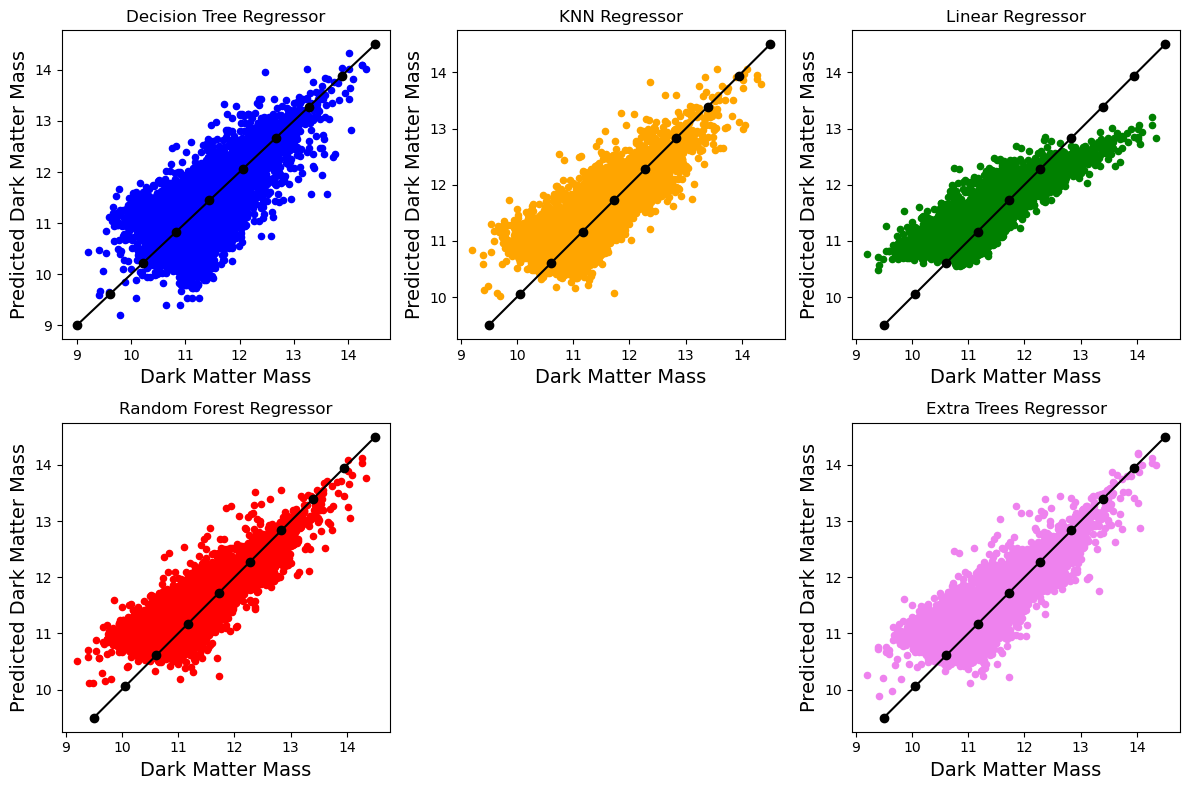

In [40]:
plt.figure(figsize=(12, 8))

# DT
plt.subplot(2, 3, 1)
m = np.linspace(9, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,Cvpred, s = 20, c = 'blue')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Decision Tree Regressor')

# KNN
plt.subplot(2, 3, 2)
m = np.linspace(9.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,KCvpred, s = 20, c = 'orange')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('KNN Regressor')

# LIN
plt.subplot(2, 3, 3)
m = np.linspace(9.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,LCvpred, s = 20, c = 'green')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Linear Regressor')

# RF
plt.subplot(2, 3, 4)
m = np.linspace(9.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,FOCvpred, s = 20, c = 'red')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Random Forest Regressor')


# ETR
plt.subplot(2, 3, 6)
m = np.linspace(9.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,ETCvpred, s = 20, c = 'violet')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Extra Trees Regressor')

plt.tight_layout()
plt.savefig('FOdiffSMBM models.png')
plt.show()